# Introdução à Otimização: Lista 2
Professor Amit Bhaya 
2022.2

In [2]:
using Plots
using JuMP
using Clp
using LinearAlgebra
using NamedArrays
using Ipopt
using Distributions

## Problema 1 (Alocação ótima):
Uma pequena empresa de aluguel de carros possui uma frota de 94 veículos distribuídos em 10 cidadess. A localização de cada agência é dada pelas coordenadas cartesianas $(x,y)$ (km) e supõe-se que a distância rodoviária entre cada agência é 1.3 vezes a distância euclideana entre elas (isto é, 1.3 vezes o comprimento da linha reta juntando as cidades). A tabela abaixo indica as coordenadas de cada agência, o número de veículos demandados no dia seguinte pela manhã e o número de veículos disponíveis na agência na noite anterior a este dia.

| N. da agência | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10|
|---------------|---|---|---|---|---|---|---|---|---|---|
| Coordenada x  |	0 |	20 | 18 | 30 | 35 |	33 | 5 | 5 | 11 | 2 |
| Coordenada y  |	0 |	20 | 10 | 12 | 0 | 25 |	27 | 10 | 0 | 15 |
| Demanda de veículos | 10 | 6 | 8 | 11 | 9 | 7 | 15 |	7 |	9 |	12 |
| Veículos disponíveis |	8 |	13 | 4 | 8 | 12 | 2 | 14 | 11 |	15 | 7 |

Supondo o custo de deslocar um veículo de uma agência para outra é R\$0.50 por km, determine o movimento dos veículos que permite o atendimento da demanda em cada agência, minimizando o custo de deslocamento deles.

### Solução do problema 1:

In [35]:
# Travel cost ($/km)
cost = 0.5

# Coordinates of each agency
coords = [0 0; 20 20; 18 10; 30 12; 35 0; 33 25; 5 27; 5 10; 11 0; 2 15]

# Demand for each agency
demand = [10; 6; 8; 11; 9; 7; 15; 7; 9; 12]

# Car availability for each agency
availability =[8; 13; 4; 8; 12; 2; 14; 11; 15; 7]

# Euclidean constant
k = 1.3

# Distance matrix
D = zeros(10, 10)

for i in range(1,10)
    for j in range(1,10)
        D[i, j] = k * ((coords[i,1] - coords[j,1])^2 + (coords[i,2] - coords[j,2])^2)^(1/2)
    end
end

# Cost matrix
C = 0.5 * D
#show(stdout, "text/plain", C)

m = Model(Clp.Optimizer)

@variable(m, transfers[1:10, 1:10])
set_optimizer_attribute(m, "LogLevel", 0)

for i in 1:10
    # Law of conservation of cars
    @constraint(m, sum(transfers[i,:]) == 0)

    # Demand of an agency should be satisfied
    @constraint(m, sum(transfers[:,i]) == demand[i] - availability[i])

    # Agencies can't transfer cars to themselves
    for j in 1:10
        if i == j
            # Car origin
            @constraint(m, transfers[i,j] ≤ 0)
        else
            # Car destination
            @constraint(m, transfers[i,j] ≥ 0)
        end
    end
end

@objective(m, Min, dot(C, transfers))

optimize!(m)

result = JuMP.value.(transfers)
display(result)
println("Custo = R\$ ", dot(C, result))
println("Necessidade por agência = ", [demand[i] - availability[i] for i in 1:10])
println("Recebimento por agência = ", [floor(Int, sum(result[:,i])) for i in 1:10])


10×10 Matrix{Float64}:
 0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0
 0.0  -7.0  1.0  0.0   0.0  5.0  1.0   0.0   0.0  0.0
 0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0
 0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0
 0.0   0.0  0.0  3.0  -3.0  0.0  0.0   0.0   0.0  0.0
 0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0
 0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0
 0.0   0.0  0.0  0.0   0.0  0.0  0.0  -5.0   0.0  5.0
 2.0   0.0  3.0  0.0   0.0  0.0  0.0   1.0  -6.0  0.0
 0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0

Custo = R$ 152.6390163229563
Necessidade por agência = [2, -7, 4, 3, -3, 5, 1, -4, -6, 5]
Recebimento por agência = [2, -7, 4, 3, -3, 5, 1, -4, -6, 5]


## Problema 2 (Ajuste de curva):
Os pontos plotados no gráfico (escala logarítmica) mostram os números de transistores $N$ em um microprocessador versus o  ano $t$. Encontre a reta de melhor ajuste, no sentido de mínimos quadrados, utilizando o modelo:
$$
\log_{10} N = \theta_1 + \theta_2 (t - 1970)
$$
Note que $\theta_1$ é a predição do modelo do logaritmo do número de transistores em 1970, e $10^{\theta_2}$ é a predição do modelo da taxa de aumento no número de transistores por ano.

1. Encontre os coefcientes $\theta_1, \theta_2$ que minimizem o erro quadrático (erro RMS) e plote os pontos previstos junto com os dados, mostrando os erros RMS.
2. Utilize seu modelo para prever o número de transistores no microprocessador da IBM Z13, lançado em 2015. O valor verdadeiro está em torno de $4 \times 10^9$.
3. Compare seu resultado com a lei de Moore, enunciada pelo Gordon Moore (cofundador da Intel), que afirma que o número de transistores por circuito integrado dobra a cada 1,5 a 2 anos (aproximadamente).

Dados:

| Ano | Transistores |
|-------------|---|
| 1971|	2,250 |
| 1972 |2,500 |
| 1974 |5,000| 
| 1978 | 29,000 | 
| 1982 | 120,000 | 
| 1985 | 275,000 | 
| 1989 | 1,180,000 | 
| 1993 | 3,100,000 | 
| 1997 | 7,500,000 | 
| 1999 | 24,000,000 | 
| 2000 | 42,000,000 | 
| 2002 | 220,000,000 | 
| 2003 | 410,000,000 | 

Estes dados estão plotados abaixo, em escala logarítmica no eixo vertical (número de transistores) e o ano correspondente em escala linear no eixo horizontal.

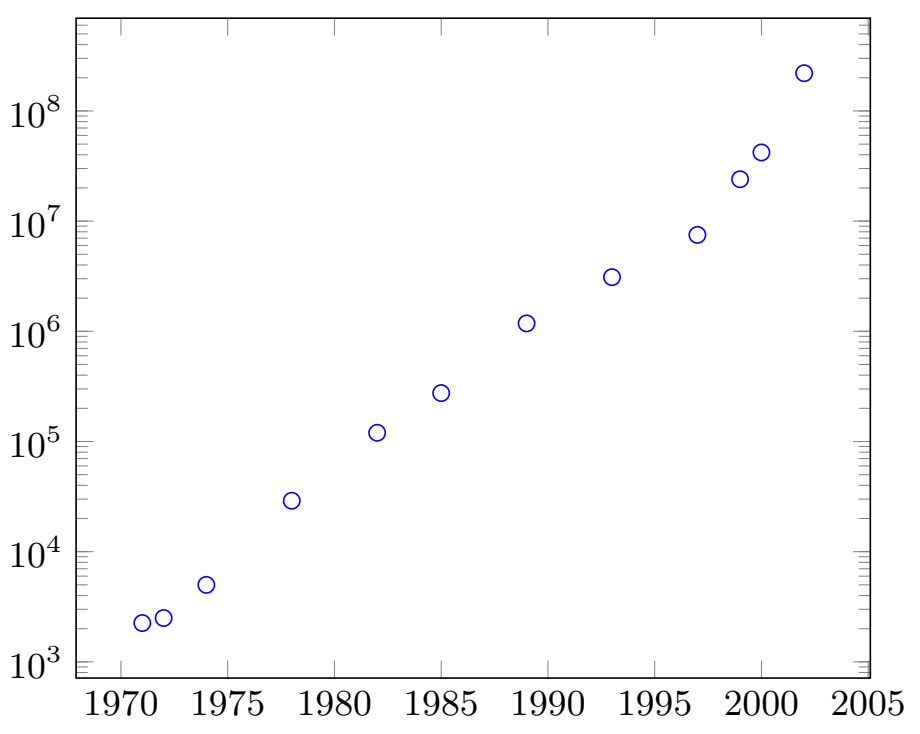

A título de curiosidade, aqui vão alguns dados um pouco mais recentes:

> We went from the 6502 microprocessor, in 1975 with 3510 transistors and used in the Apple A11 Bionic processor (2017)used in the iPhone 8, has 4.3 billion transistors— more than a million times as many as the 6502.

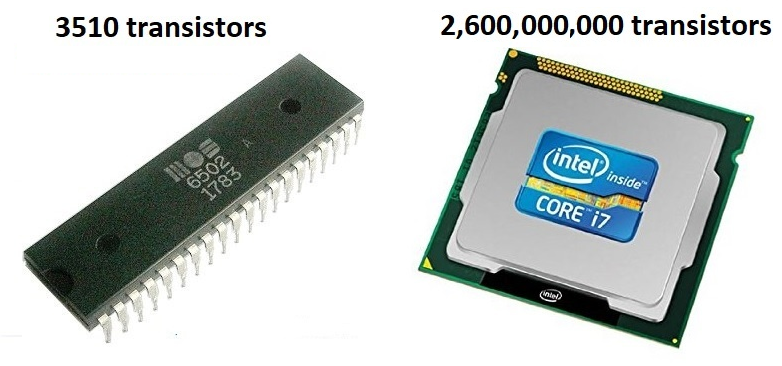

> The AMD Ryzen 5 1600 (2017) has 4.8 billion transistors. The Centriq 2400 (2017), designed by Qualcomm for their data centers, has 18 billion transistors.

### Solução do problema 2:




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



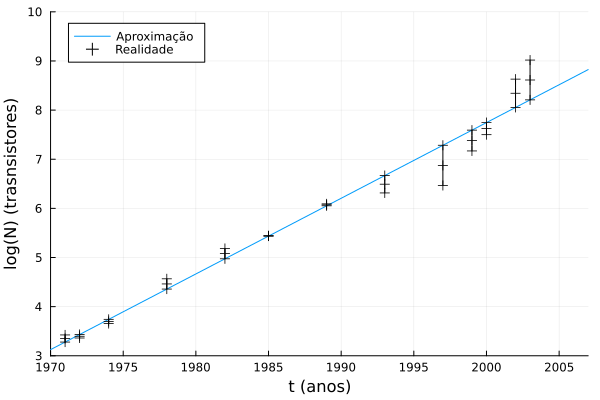

In [4]:
# 1) Coeficient search with Least Squares Method
# Raw data
rawdata = [
    1971  2250;
    1972  2500;
    1974  5000;
    1978  29000 ;
    1982  120000 ;
    1985  275000 ;
    1989  1180000 ;
    1993  3100000 ;
    1997  7500000 ;
    1999  24000000 ;
    2000  42000000 ;
    2002  220000000 ;
    2003  410000000 ]

# Transistor quantity in log base 10 and parsed year
data = [rawdata[:,1].-1970 log10.(rawdata[:,2])]

# Input and output matrix
A = [ones(length(data[:,1]),1) data[:,1]]
b = data[:,2]

# Optimization using Ipopt
m = Model(Ipopt.Optimizer)
set_optimizer_attribute(m, "print_level", 0)
@variable(m, x[1:2])
@objective(m, Min, sum((A*x - b).^2))
optimize!(m)

# Coeficients
θ = JuMP.value.(x)
# display(θ)

function new_plot()
  plot(xlabel="t (anos)", ylabel="log(N) (trasnsistores)",
    legend=:topleft,
    xticks=1970:5:2007,
    yticks=3:1:10,
    xlims=(1970, 2007), ylims=(3, 10))
end

f(t) = θ[1] + θ[2]*(t - 1970)

# Error vector
error = [abs.(f.(rawdata[:,1]) - log10.(rawdata[:,2]))]

p = new_plot()

plot!(p, f, label="Aproximação")

scatter!(p, rawdata[:,1], data[:,2], yerr = error', label="Realidade", marker=(:cross, :black, 5))


In [5]:
# 2) Transistor quantity prediction
aprx = f(2015)
real = log10(4*10^9)

println("Aproximação = ", aprx, " log(transistores)")
println("Realidade   = ", real, " log(transistores)")
println("Erro        = ", log10(10^(aprx) - 10^(real)), " log(transistores)")

Aproximação = 10.056410726801357 log(transistores)
Realidade   = 9.602059991327963 log(transistores)
Erro        = 9.868470266590013 log(transistores)


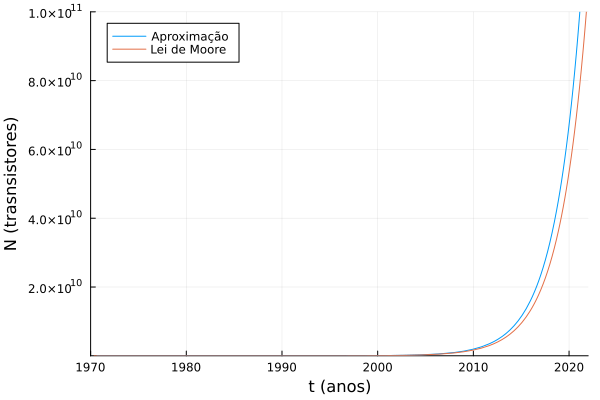

In [6]:
# 3) Comparison with Moore's Law
function new_plot()
  plot(xlabel="t (anos)", ylabel="N (trasnsistores)",
    legend=:topleft,
    xlims=(1970, 2022), ylims=(2000, 10^11))
end

# Estimated transistor count
f10(t) = 10^(θ[1] + θ[2]*(t - 1970))

# Moore's Law transistor count
m10(t) = 2^(log2(2250) + (t - 1971)/2)

p = new_plot()
plot!(p, f10, label="Aproximação")
plot!(p, m10, label="Lei de Moore")

## Problema 3:
Existem muitas maneiras de modelar o relacionamento entre uma sequência de entrada $\{u_1, u_2,\dots\}$ e outra de saída $\{y_1, y_2,\dots\}$. Vimos o modelo média movel (_Moving Average_ ou MA), no qual cada saída é representada por uma combinação linear dos $k$ entradas mais recentes:
$$ \text{MA:}\quad y_t \approx b_1u_t + b_2u_{t-1} + \dots + b_ku_{t-k+1} $$

Utilizamos mínimos quadrados para achar os coeficientes $b_1,\dots, b_k$. 

E se não tivéssemos acesso as entradas? Neste caso, teríamos que prever valores futuros de $y$ baseados apenas nos valoers prévios de $y$? Uma maneira de fazer isso é utilizar o chamado modelo autoregressivo (AR), no qual cada saída é representada (aproximada) por uma combinação linear dos $\ell$ saída mais recentes (excluindo a atual):
$$ \text{AR:}\quad y_t \approx a_1y_{t-1} + a_2y_{t-2} + \dots + a_\ell y_{t-\ell} $$

É claro que, se as entradas contêm informações pertinentes, o método AR não terá desempenho melhor que o método MA.


Utilizando o conjunto de dados fornecido na célula abaixo, plote o verdadeiro  $y$, e, nos mesmos eixos, plote também a estimativa $\hat{y}_{ma}$ utilizando o modelo MA, e a estimativa $\hat{y}_{ar}$, utilizando o modelo AR. Utilize $k = l = 5$ para os modelos. Para quantificar a diferença entre as estimativas, compute também as normas dos erros em ambos os casos, i.e., $\|y - \hat{y}_{A}\|$, sendo $A= ma, ar$.

Uma outra possibilidade é combinar AR and MA. Obviamente, este modelo é chamado ARMA (_Autoregressive Moving Average_):
$$ \text{ARMA:}\quad y_t \approx a_1y_{t-1} + a_2y_{t-2} + \dots + a_\ell y_{t-\ell} + b_1u_t + b_2u_{t-1} + \dots + b_ku_{t-k+1} $$

Resolve o problema novamente, desta vez usando um modelo ARMA com $k = \ell = 1$. Plote $y$ and $\hat{y}_{arma}$, e compute também o erro $\|y - \hat{y}_{arma}\|$.

### Dados para o problema 3:

In [7]:
raw = [-0.9188 -1.0773
-0.6159 -0.9419
0.1959 -0.0915
-0.0316 0.0245
-1.3455 -1.3239
-0.0513 -0.3536
0.1471 0.1032
-1.1615 -1.0702
0.5478 0.2722
0.6096 0.9127
-0.9706 -0.4672
0.3018 0.1654
0.2039 0.3515
-1.6833 -1.5158
0.0057 -0.2207
1.4925 1.5337
0.0113 1.2458
-1.3563 -0.8868
-1.288 -1.488
-0.6159 -0.9394
-0.639 -0.884
-0.9488 -1.2152
-0.3364 -0.6755
0.8631 0.6695
1.4679 2.0192
1.0442 2.4178
0.4562 1.6812
0.6309 1.2713
1.3197 1.8668
1.5108 2.6653
1.2262 2.8286
-0.0127 1.4358
0.4645 0.8995
0.5191 0.8685
-0.7274 -0.3292
-0.6509 -0.7965
0.0901 -0.1906
1.4747 1.4607
1.5163 2.7007
0.3898 2.0539
0.1405 0.9278
0.2109 0.4734
-0.8675 -0.7146
-1.4313 -1.6855
0.0905 -0.2711
0.7334 0.7681
0.8687 1.3874
1.658 2.4258
0.3784 2.0024
-0.1594 0.6279
1.2091 1.3279
1.0389 1.9324
0.7494 1.7987
-0.229 0.5894
-1.5111 -1.3858
0.3298 0.0347
1.481 1.6587
1.2702 2.5347
-0.1956 1.2286
-0.8984 -0.53
-0.2123 -0.4387
0.6902 0.5329
0.3256 0.7312
-1.1566 -0.823
-0.349 -0.5661
0.9869 0.8105
0.892 1.5486
-0.7315 0.1209
-0.2765 -0.2639
1.0961 0.9674
0.959 1.7094
-0.4793 0.4625
-0.129 -0.0227
-0.0896 -0.1439
0.1326 0.0645
0.5292 0.5793
-0.4606 -0.1214
0.3742 0.298
0.8715 1.0606
1.3862 2.0386
1.2687 2.5662
1.203 2.6041
0.166 1.5009
-0.0269 0.4687
0.1963 0.2807
-0.4706 -0.3694
0.7855 0.617
1.2281 1.6969
0.205 1.2934
-0.8645 -0.3791
0.1419 -0.0276
0.2251 0.2533
-0.4831 -0.3436
-0.1577 -0.3082
-0.7281 -0.8429
0.1397 -0.1449
0.0851 0.1008
-0.2105 -0.1442
-0.011 -0.0843
-0.2845 -0.3122]

u = raw[:,1];
y = raw[:,2];

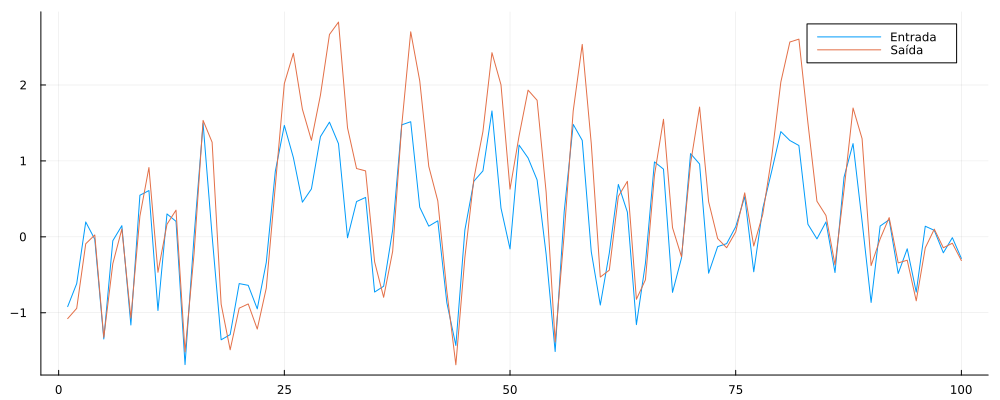

In [8]:
# 0) Input and output plot
function new_plot()
  plot(size=(1000,400))
end

p = new_plot()

plot!(p, u, label="Entrada")
plot!(p, y, label="Saída")

Erro total = 2.460854388269911


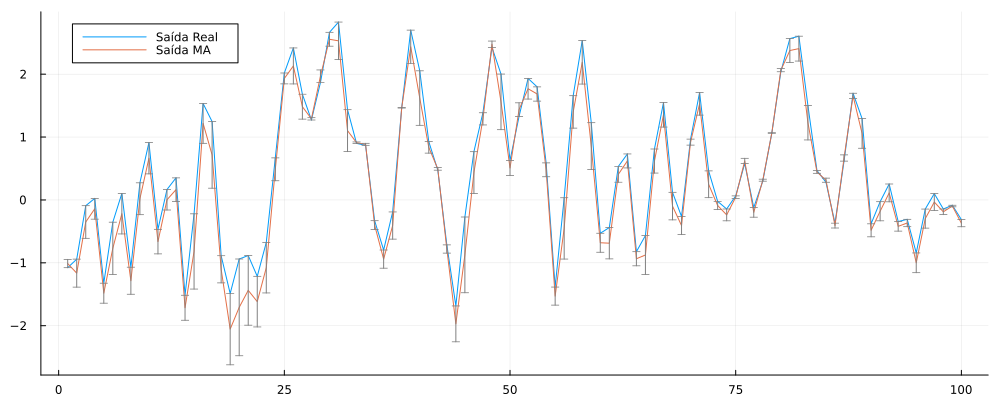

In [9]:
# 1) MA Model
# Properties of the model and signal
T = length(u)
k = 5
U = zeros(T, k)

# Creating the signal matrix for the model
for t in 1:k
    # U[t] = [ut ut-1 ut-2 ut-3 ut-4]
    U[t:end,t] = u[1:end-t+1]
end

# Most reliable LSM
b = U\y
yma = U*b

# Plot
function new_plot()
  plot(size=(1000,400),legend=:topleft)
end

p = new_plot()

# Error calculation
error = yma - y
println("Erro total = ", norm(error))

plot!(p, y, label="Saída Real")
plot!(p, yma, label="Saída MA", yerr=error, markerstrokecolor=:grey)


Erro total = 7.436691765656793


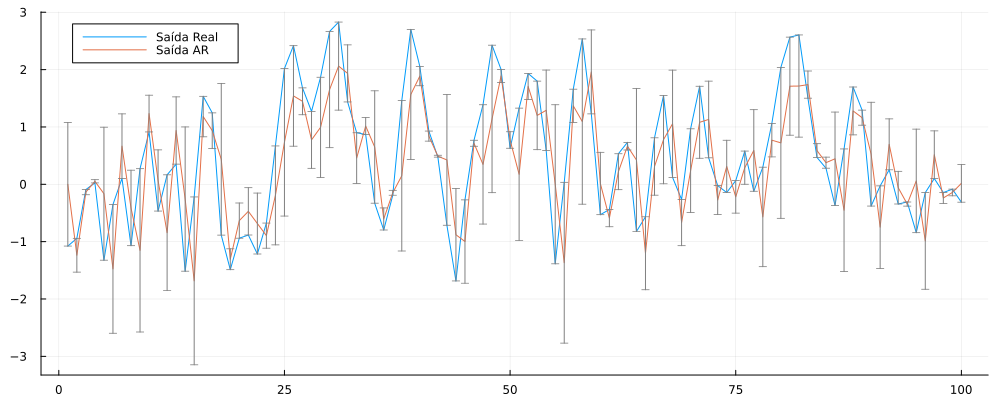

In [10]:
# 2) AR Model
# Properties of the model and signal
T = length(u)
l = 5
Y = zeros(T, l)

# Creating the signal matrix for the model
for t in 1:k
    # Y[t] = [yt-1 yt-2 yt-3 yt-4 yt-5]
    Y[t+1:end,t] = y[1:end-t]
end

# Most reliable LSM
a = Y\y
yar = Y*a

# Plot
function new_plot()
  plot(size=(1000,400),legend=:topleft)
end

p = new_plot()

# Error calculation
error = yar - y
println("Erro total = ", norm(yar-y))

plot!(p, y, label="Saída Real")
plot!(p, yar, label="Saída AR", yerr=error, markerstrokecolor=:grey)


Erro total = 1.8565828148734604


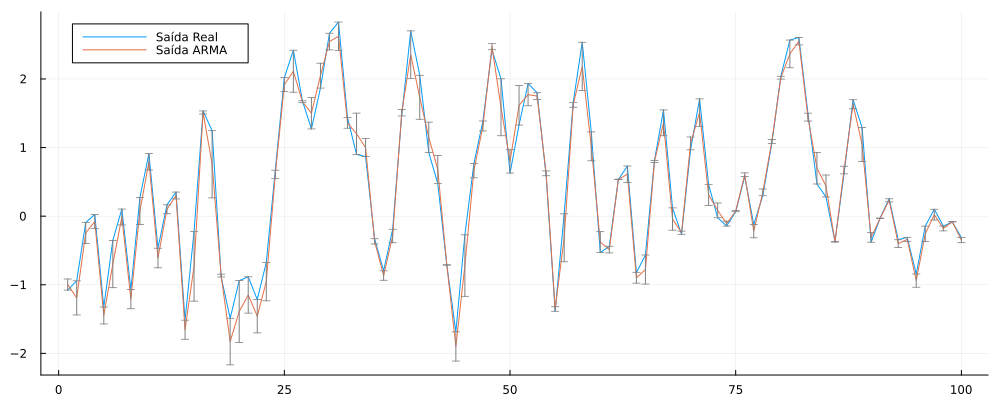

In [11]:
# 3) ARMA Model
# Properties of the model and signal
T = length(u)
k = 1
l = k
C = zeros(T, k+l)

# Creating the signal matrix for the model
for t in 1:k
    # U[t] = [ut ut-1 ut-2 ut-3 ut-4]
    C[t:end,t] = u[1:end-t+1]

    # Y[t] = [yt-1 yt-2 yt-3 yt-4 yt-5]
    C[t+1:end,t+l] = y[1:end-t]
end

# Most reliable LSM
c = C\y
yarma = C*c

# Plot
function new_plot()
  plot(size=(1000,400),legend=:topleft)
end

p = new_plot()

# Error calculation
error = yarma - y
println("Erro total = ", norm(yarma-y))

plot!(p, y, label="Saída Real")
plot!(p, yarma, label="Saída ARMA", yerr=error, markerstrokecolor=:grey)


## Problema 4 (LP dual):
Considere o programa linear 

\begin{aligned}
& \text{minimize}~2x_1 + 9x_2 + 3x_3 \\
&\text{sujeito a}~-2x_1 + 2x_2 + x_3 \geq 1 \\
&\qquad \qquad x_1 + 4x_2 - x_3 \geq 1 \\
& \qquad \qquad x_1,x_2,x_3 \geq 0
\end{aligned}


1. Escreve o dual deste problema e resolva graficamente.
2. Utilize folga complementar para obter a solução ao problema primal.
3. Repita o problema, considerando que a primeira restrição é substituída por $-3x_1 + 2x_2 + x_3 \geq 1$. É possível utilizar folga complementar para obter a solução ao problema dual?

### Solução do problema 4:

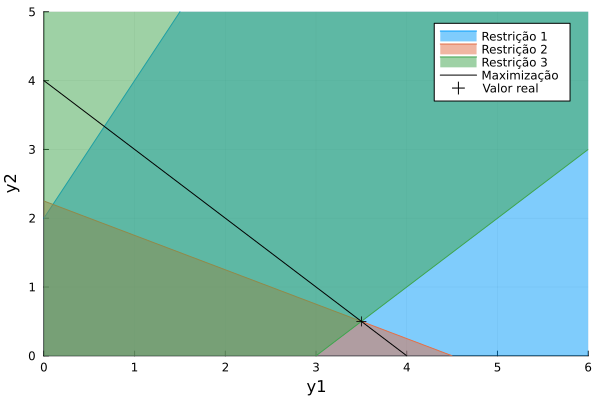

In [12]:
# 1) Dual problem graphical solution
function new_plot()
  plot(xlabel="y1", ylabel="y2",
    legend=:topright,
    xlims=(0, 6), ylims=(0, 5)) # Implicit x,y > 0
end

y1(x) = ( 2x + 2)       # -2x +  y ≤ 2
y2(x) = (-2x + 9) / 4   #  2x + 4y ≤ 9
y3(x) = (  x - 3)       #   x -  y ≤ 3

l1(x) = (-x + 4)

p = new_plot()

plot!(p, y1, fill=(0, 0.5, :auto), label="Restrição 1")
plot!(p, y2, fill=(0, 0.5, :auto), label="Restrição 2")
plot!(p, y3, fill=(6, 0.5, :auto), label="Restrição 3")
plot!(p, l1, label="Maximização", line=(1, :black, :solid))

scatter!(p, [3.5], [0.5], label="Valor real", marker=(:cross, :black, 5))

A forma dual deste problema:
\begin{aligned}
& \text{maximize}~y_1 +y_2 \\
&\text{sujeito a}~-2y_1 +y_2 \leq 2 \\
&\qquad \qquad 2y_1 + 4y_2  \leq 9 \\
&\qquad \qquad y_1 - y_2  \leq 3 \\
& \qquad \qquad y_1,y_2 \geq 0
\end{aligned}
Pelo gráfico sabemos que a primeira restrição tem folga (a variação da restrição até certo ponto, não afeta o resultado). Desta forma, $x_1=0$ e o custo deve ser $4$.

In [13]:
# 2) Primal solution accounting for complementary slack
b = [1; 1]

A = [
    -2  2  1;
     1  4 -1;
    ]  

c = [2; 9; 3]


m = Model(Clp.Optimizer)
set_optimizer_attribute(m, "LogLevel", 0)

@variable(m, 0 ≤ x[1:3])

@constraint(m, A * x .== b)

# Slack variable
@constraint(m, x[1] == 0)

# Equal cost constraint
@constraint(m, 9x[2] + 3x[3] == 4)

@objective(m, Min, dot(c', x))

optimize!(m)

println("max = ", dot(c', JuMP.value.(x)))
println("x1  = ", JuMP.value.(x[1]))
println("x2  = ", JuMP.value.(x[2]))
println("x3  = ", JuMP.value.(x[3]))

max = 4.0
x1  = 0.0
x2  = 0.33333333333333337
x3  = 0.3333333333333333


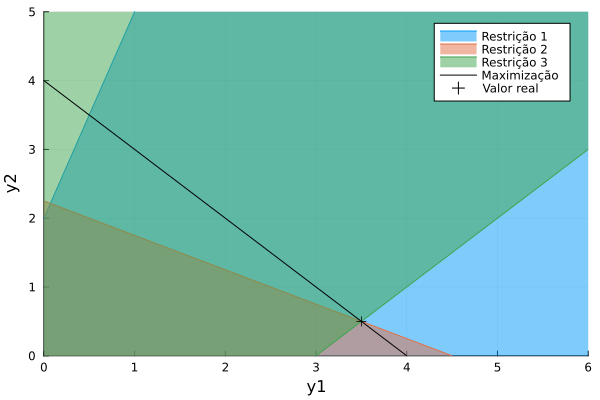

In [14]:
# 3) Changed first primal constraint
function new_plot()
  plot(xlabel="y1", ylabel="y2",
    legend=:topright,
    xlims=(0, 6), ylims=(0, 5)) # Implicit x,y > 0
end

y1(x) = ( 3x + 2)       # -2x +  y ≤ 2
y2(x) = (-2x + 9) / 4   #  2x + 4y ≤ 9
y3(x) = (  x - 3)       #   x -  y ≤ 3

l1(x) = (-x + 4)

p = new_plot()

plot!(p, y1, fill=(0, 0.5, :auto), label="Restrição 1")
plot!(p, y2, fill=(0, 0.5, :auto), label="Restrição 2")
plot!(p, y3, fill=(6, 0.5, :auto), label="Restrição 3")
plot!(p, l1, label="Maximização", line=(1, :black, :solid))

scatter!(p, [3.5], [0.5], label="Valor real", marker=(:cross, :black, 5))

A nova primeira restrição para a primal não afeta a aplicabilidade da folga complementar. O resultado é idêntico. Veja:

In [15]:
b = [1; 1]

A = [
    -3  2  1;
     1  4 -1;
    ]  

c = [2; 9; 3]


m = Model(Clp.Optimizer)
set_optimizer_attribute(m, "LogLevel", 0)

@variable(m, 0 ≤ x[1:3])

@constraint(m, A * x .== b)

# Slack variable
#@constraint(m, x[1] == 0)

# Equal cost constraint
#@constraint(m, 9x[2] + 3x[3] == 4)

@objective(m, Min, dot(c', x))

optimize!(m)

println("min = ", dot(c', JuMP.value.(x)))
println("x1 = ", JuMP.value.(x[1]))
println("x2 = ", JuMP.value.(x[2]))
println("x3 = ", JuMP.value.(x[3]))

min = 4.0
x1 = 0.0
x2 = 0.3333333333333333
x3 = 0.3333333333333333


## Problema 5 (Ainda dualidade):

Utilize dualidade para encontrar a solução para o seguinte LP:
\begin{aligned}
&\text{minimize}\quad x_1 + 2x_2 + \dots + nx_n \\
&\text{sujeito a}~\quad  x_1 \geq 1 \\
& \qquad \qquad x_1 + x_2 \geq 2 \\
& \qquad \qquad \qquad \vdots \\
& \qquad \qquad x_1 + x_2 + x_3 + \cdots + x_n \geq n \\
& \qquad \qquad x_1x_2,x_3, \ldots , x_n \geq 0 \\
\end{aligned}


### Solução do problema 5:

$$
\begin{aligned}
&\text{minimize}\quad x_1 + 2x_2 + \dots + nx_n \\
&\text{sujeito a}~\quad  x_1 \geq 1 \\
& \qquad \qquad x_1 + x_2 \geq 2 \\
& \qquad \qquad \qquad \vdots \\
& \qquad \qquad x_1 + x_2 + x_3 + \cdots + x_n \geq n \\
& \qquad \qquad x_1x_2,x_3, \ldots , x_n \geq 0 \\
\end{aligned}

\Longleftrightarrow

\begin{aligned}
&\text{maximize}\quad y_1 + 2y_2 + \dots + ny_n \\
&\text{sujeito a}~\quad  y_1 + y_2 + y_3 + \cdots + y_n \leq 1 \\
& \qquad \qquad y_2 + y_3 + \cdots + y_{n} \leq 2 \\
& \qquad \qquad \qquad \vdots \\
& \qquad \qquad y_n \leq n \\
& \qquad \qquad y_1y_2,y_3, \ldots , y_n \geq 0 \\
\end{aligned}
$$
Pode-se facilmente deduzir a solução ideal para a primal, $x=(n, 0,\cdots,0)$. Mas nota-se a folga em todas suas restrições, excluindo a última. A partir disso, sabendo que as variáveis $y=(0,\cdots, 0, y_n)$ e o objetivo eh igual $n$, resolve-se o problema para confirmar que com a primeira restrição da dual $y_n = 1$, obtém-se o mesmo valor objetivo que aquele do primal.

In [16]:
# Primal problem
# Test it yourself!
n = 100

b = [1:n...]

A = LowerTriangular(ones(Int,n,n))

c = [1:n...]

m = Model(Clp.Optimizer)
set_optimizer_attribute(m, "LogLevel", 0)

@variable(m, 0 ≤ x[1:n])
@constraint(m, A * x .≥ b)
@objective(m, Min, dot(c', x))

optimize!(m)

println("min = ", dot(c', JuMP.value.(x)))

min = 100.0


In [17]:
# Dual problem
# Test it yourself!
n = 100

b = [1:n...]

A = LowerTriangular(ones(Int,n,n))

c = [1:n...]

m = Model(Clp.Optimizer)
set_optimizer_attribute(m, "LogLevel", 0)

@variable(m, 0 ≤ x[1:n])
@constraint(m, A' * x .≤ c')
@objective(m, Max, dot(b', x))

optimize!(m)

println("max = ", dot(b', JuMP.value.(x)))

max = 100.000000000005


## Problema 6 (controle ótimo de energia mínima):

Um modelo simples de um veiculo se deslocando em uma dimensão é:
$$
\begin{bmatrix} s_1(t+1)\\ s_2(t+1) \end{bmatrix} = 
\begin{bmatrix} 1 & 1 \\ 0 & 0.95 \end{bmatrix}
\begin{bmatrix} s_1(t)\\ s_2(t) \end{bmatrix}  +
\begin{bmatrix} 0\\ 0.1 \end{bmatrix} u(t), \quad t = 0,1,2, \ldots
$$
sendo $s_1(t)$ a posição do veículo no instante $t$, $s_2 (t)$ a velocidade no instante $t$, e $u(t)$ a entrada (sinal de atuação). Essas equações de estado representam o fato de que a entrada (de atuação) afeta a velocidade, que por sua vez afeta a posição. O elemento $0.95$ significa que a velocidade decai em 5\% em um período de amostragem (por exemplo, por causa de atrito), se nenhuma atuação for aplicada. O veículo está em repouso no instante inicial, i.e., $s_1 (0) = s_2 (0) = 0$. Pede-se a resolução do problema de controle (ótimo) de energia mínima. Isto é, para um dado horizonte $N$, escolhe as entradas $u(0), \ldots, u(N-1)$ de modo a minimizar a energia total gasta, dada pela expressão:
$$
E = \sum_{t=0}^{N-1} u (t)^2.
$$
Adicionalmente, a sequência de entradas deve satisfazer as restrições $s_1 (N) = 10$, $s_2 (N) = 0$ -- u seja, a tarefa é de levar o veículo até a posição final $s_1 (N) = 10$, com velocidade final $s_2 (N) = 0$ da maneira mais eficiente possível (i.e., com o menor gasto de energia $E$).

- Formule este problema de controle ótimo de energia mínima como um problem de norma mínima:
\begin{align}
& \text{minimize}\quad \|x\|^2\\
& \text{sujeito a} \quad Cx = d.
\end{align}
explicitando a variáves (de decisão) $x$, e a definição da matriz $C$ e do vetor $d$ em termos dos dados do problema.

1. Resolva o problema para $N=30$, plotando o coontrole ótimo $u(t)$, e as posições $s_1 (t)$ e velocidades $s_2 (t)$ ótimas correspondentes.
2. Resolva o problema para $N = 2, 3, \ldots, 29$. Para cada valor de $N$, calcule a energia consumida pela sequência de controle ótimo aplicada. Plot $E$ contra $N$, utilizando escala logatímica para $E$.
3. Resolva o problema permitindo um desvio na posição final penalizados pelo acrescimo do termo $(s_1 (N) - 10)^2$. O novo problema de controle ótimo passa a ser o problema de otimizar a função de energia penalizada pelo novo termo. Formule este novo problema como um problema de norma mínima e resolva para $N=30$. Plote a sequência de controle ótimo, a posição $s_1 (t)$ e a velocidade $s_2 (t)$ resultantes.

### Solução do problema 6:

Energia total aplicada = 5.714127190494349


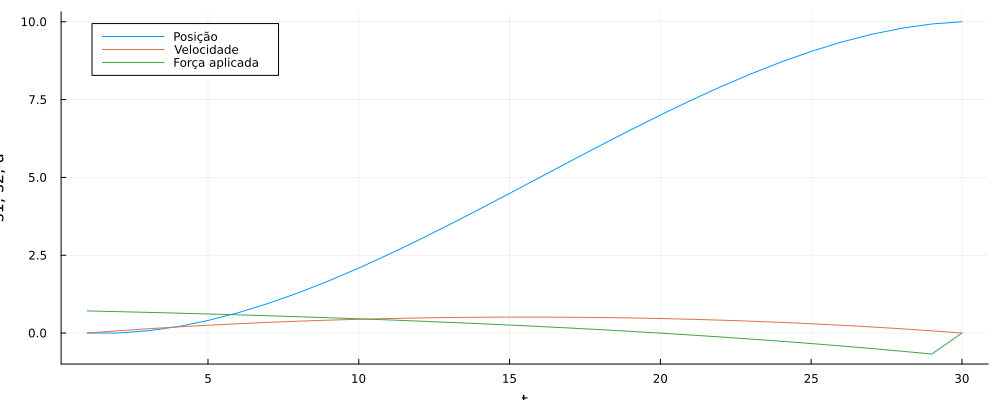

In [18]:
# 1) Optimal control model
# Total instances
T = 30

# Optimization using Ipopt
m = Model(Ipopt.Optimizer)
set_optimizer_attribute(m, "print_level", 0)

# S is a 2xT matrix, where the lines are position and speed
# for every instance t represented by a column
@variable(m, S[1:2,1:T])
# U is a 1xT matrix to describe the force aplied to the system 
@variable(m, U[1:1,1:T])

# Initial conditions
@constraint(m, S[:,1] .== [0; 0])

for t in 1:T-1
    # System dinamic description
    @constraint(m, S[1,t] + S[2, t] == S[1,t+1])
    @constraint(m, 0.95.*S[2,t] + 0.1.*U[1,t] == S[2,t+1])
end

# Final conditions
@constraint(m, S[:,T] .== [10; 0])

@objective(m, Min, sum(U.^2))
optimize!(m)

println("Energia total aplicada = ", sum(JuMP.value.(U).^2))

function new_plot()
  plot(xlabel="t", ylabel="s1, s2, u", size=(1000,400),
    legend=:topleft)
end

p = new_plot()

plot!(p, 1:T, JuMP.value.(S[1,:]), label="Posição")
plot!(p, 1:T, JuMP.value.(S[2,:]), label="Velocidade")
plot!(p, 1:T, JuMP.value.(U)', label="Força aplicada")

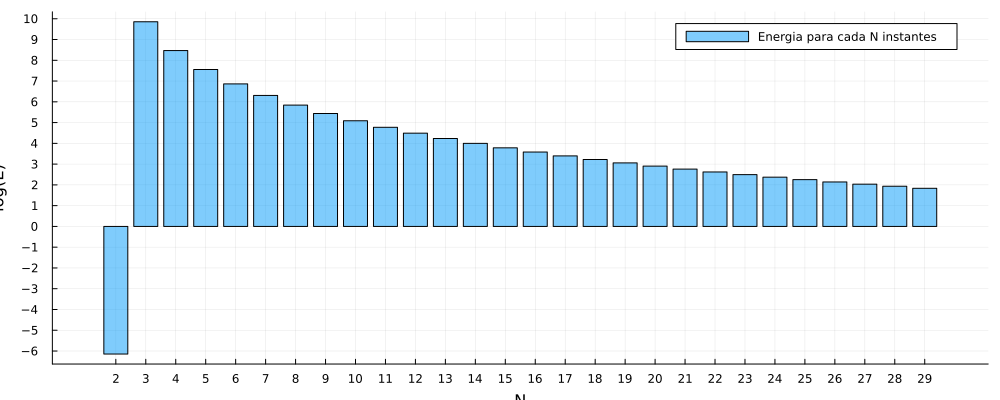

In [19]:
# 2) Optimal control model for N ∈ [2,29]
N = 29

# Problem abstraction
function CarSim(T)
  # Optimization using Ipopt
  m = Model(Ipopt.Optimizer)
  set_optimizer_attribute(m, "print_level", 0)

  # S is a 2xT matrix, where the lines are position and speed
  # for every instance t represented by a column
  @variable(m, S[1:2,1:T])
  # U is a 1xT matrix to describe the force aplied to the system 
  @variable(m, U[1:1,1:T])

  # Initial conditions
  @constraint(m, S[:,1] .== [0; 0])

  for t in 1:T-1
      # System dinamic description
      @constraint(m, S[1,t] + S[2, t] == S[1,t+1])
      @constraint(m, 0.95.*S[2,t] + 0.1.*U[1,t] == S[2,t+1])
  end

  # Final conditions
  @constraint(m, S[:,T] .== [10; 0])

  @objective(m, Min, sum(U.^2))
  optimize!(m)

  return (JuMP.value.(S[1,:]), JuMP.value.(S[2,:]), JuMP.value.(U)')
end

function new_plot()
  plot(xlabel="N", ylabel="log(E)", size=(1000,400), 
    yticks=-10:1:10,
    xticks=2:1:N,
    legend=:topright)
end

p = new_plot()

E = zeros(N)

for t in 2:N
  E[t] = sum(CarSim(t)[3].^2)
end

bar!(p, 2:N, log.(E[2:end]), fill=(0, 0.5, :auto), label="Energia para cada N instantes")

Energia total aplicada = 5.113094814836877
Distância máxima       = 9.459473644407277


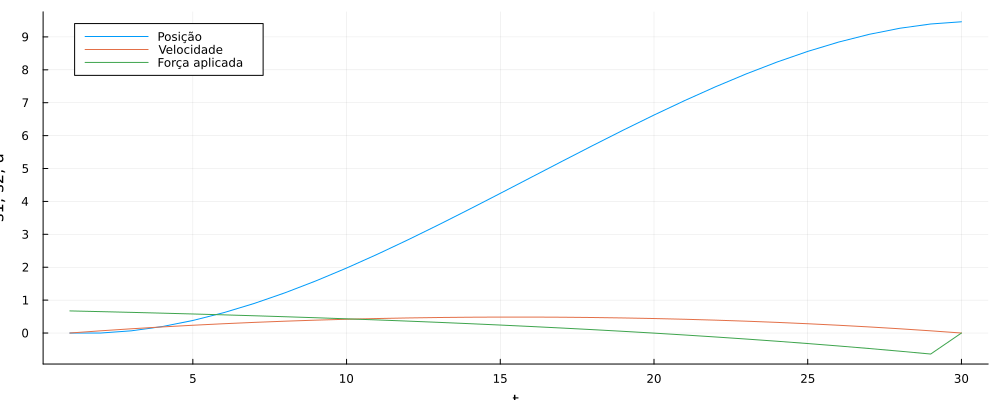

In [20]:
# 3) Distance pelanty
# Total instances
T = 30
λ = 1

# Optimization using Ipopt
m = Model(Ipopt.Optimizer)
set_optimizer_attribute(m, "print_level", 0)

# S is a 2xT matrix, where the lines are position and speed
# for every instance t represented by a column
@variable(m, S[1:2,1:T])
# U is a 1xT matrix to describe the force aplied to the system 
@variable(m, U[1:1,1:T])

# Initial conditions
@constraint(m, S[:,1] .== [0; 0])

for t in 1:T-1
    # System dinamic description
    @constraint(m, S[1,t] + S[2, t] == S[1,t+1])
    @constraint(m, 0.95.*S[2,t] + 0.1.*U[1,t] == S[2,t+1])
end

# Final conditions
@constraint(m, S[2,T] .== 0)

@objective(m, Min, sum(U.^2) + λ*(S[1,T] - 10)^2)
optimize!(m)

println("Energia total aplicada = ", sum(JuMP.value.(U).^2))
println("Distância máxima       = ", JuMP.value.(S[1,T]))

function new_plot()
  plot(xlabel="t", ylabel="s1, s2, u", size=(1000,400),
    yticks=-2:1:10,
    legend=:topleft)
end

p = new_plot()

plot!(p, 1:T, JuMP.value.(S[1,:]), label="Posição")
plot!(p, 1:T, JuMP.value.(S[2,:]), label="Velocidade")
plot!(p, 1:T, JuMP.value.(U)', label="Força aplicada")

## Problema 7 (Ajuste de uma curva constante por pedaços):

Considere um sinal ruidoso (sequência de pontos) que é aproximadamente constante por pedaços, como ilustrado na Figura abaixo:

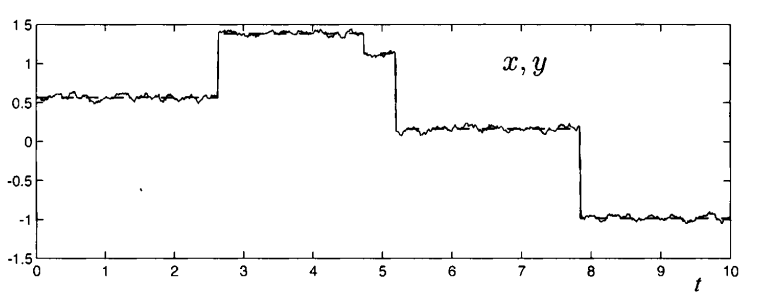

Na figura, $x \in R^n$ representa o sinal desconhecido constante por pedaços e $y$ representa a versão ruidosa medida dd sinal $x$ (ou seja, $y$ é o sinal original $x$ mais ruido). Dado $y$, gostaríamos de computar uma estimativa $\hat{x}$ do sinal original $x$ tal que $\hat{x}$ tenha o menor número de mudanças em instantes consecutivos. Modelamos esta exigência minimizando o número de elementos não-nulos do vetor de diferenças $D\hat{x}$, sendo $D \in R^{(n-1)\times n}$ a matriz de diferenças
$$
D = \begin{bmatrix} 
-1 & 1 & 0 & \cdots & 0 \\
0 & -1 & 1 & \cdots & 0 \\
0 &  0 & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & -1 & 1
\end{bmatrix}
$$
O que significa que $D\hat{x} = \left[\hat{x}_2 - \hat{x}_1, \hat{x}_3 - \hat{x}_2, \ldots , \hat{x}_n - \hat{x}_{n-1}\right]^T$. Com esta definição de $D$, chega-se ao problema de otimização:

\begin{aligned}
& \min_{\hat{x}} \|y - \hat{x}\|_2^2 \\
& \text{s.a.}~\text{card} (D\hat{x}) \leq k
\end{aligned}

Sendo $\text{card}(D\hat{x})$ o número de elementos não-nulos de $D\hat{x}$, e $k$ uma estimativa do número de saltos (degraus) no sinal. Este problema é difícil de resolver, pois $\text{card}(\cdot)$ é uma função descontínua, e pode ser substituído pela versão regularizada
\begin{aligned}
\min_{\hat{x}} \|y - \hat{x}\|_2^2  + \gamma \| (D\hat{x}) \|_p
\end{aligned}
Sendo $\gamma$ o parâmetro de regularização. Resolva o problema regularizado para $p = 1, 2$:

- Indique claramente que tipo de problema você está resolvendo (LP, QP, QCQP etc.)
- Plote os gráficos do sinal reconstruído (estimado) e o sinal original, comentando as características das soluções obtidas.

Gere seu sinal de ruído considerando que o sinal original é descrito por:
$$
x = \left\{
\begin{array}{l}
k_1 = 0.5,~\text{se}~t \in [0,2.8) \\
k_2 = 1.5,~\text{se}~t \in [2.8,4.8) \\
k_3 = 1.1,~\text{se}~t \in [4.8,5.2) \\
k_4 = 0.1,~\text{se}~t \in [5.2,7.9)\\
k_5 = -1,~\text{se}~t \in  [7.9,10]
\end{array}
\right.
$$
O sinal ruidoso $y$ é gerado a partir de $x$, acrescentando um ruido gaussiano de média $k_i$ e variância $0.01$ ao $i$-ésimo trecho constante de $x$. Forneça o par de sinais $x,y$ no *notebook* entregue. Para o problema proposto, trabalhe com 100 amostras igualmente espaçadas dos sinais contínuos gerados.

### Solução do problema 7:
O problema é do tipo QP (programação quadrática), porque possui uma função objetiva quadrática (ou polinomial) mas não restrições quadráticas (o qual a classificaria como QCQP).

Como pode ser apreciado nos gráficos quanto maior o $\gamma$ mais suave a curva e quanto menor, mais fiel ao sinal com ruído $y$ a reconstrução se torna. Intuitivamente, pode-se deduzir que existe um valor $\gamma$ para qual o erro entre o sinal original e a reconstrução é mínimo porém indecifrável sem o sinal original.


Erro de y = 1.8811177665823589
Erro de x̂1 = 1.1148912015096089
Erro de x̂2 = 1.3993839732784878


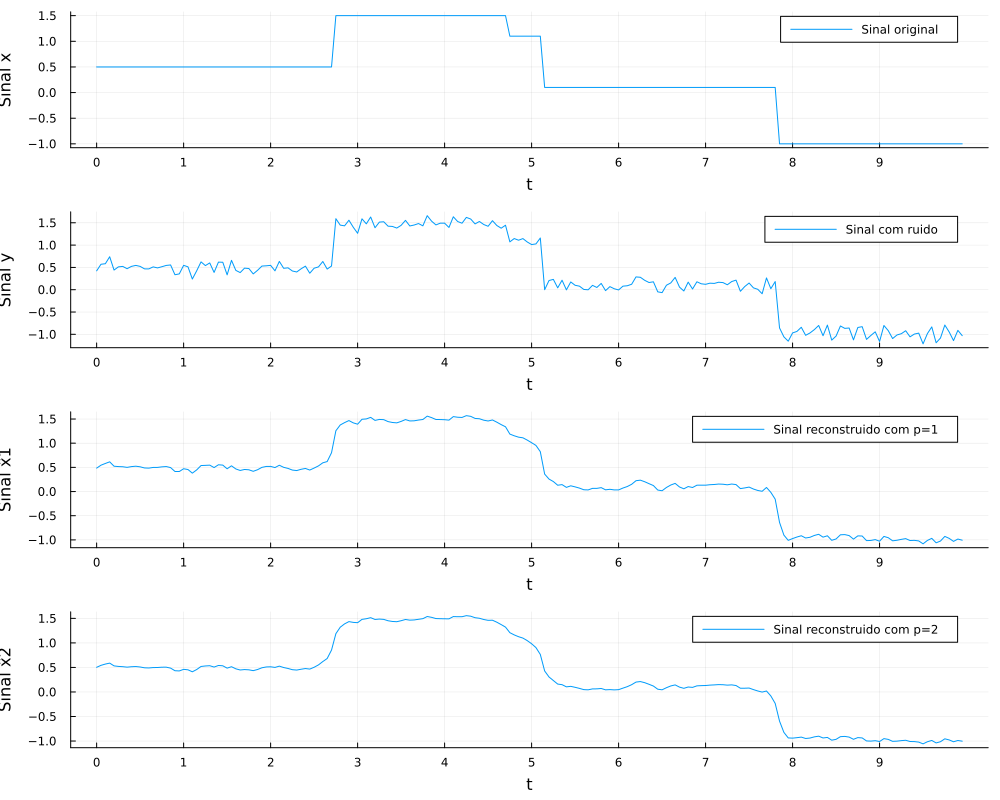

In [37]:

# Sampling size
n = 200

# Standard deviation
σ = 0.01

# Regularization coeficient
γ = [1;2]

# Generate D matrix
D = zeros(n,n)
for i in 1:n-1, j in 1:n
    if j == i
        D[i,j] = -1
    end
    if j == i+1
        D[i,j] = 1
    end
end

# Define signal x
x = ones(n)
x[ 1: trunc(Int, 0.28 * n)] .=  0.5
x[trunc(Int, 0.28 * n):trunc(Int, 0.48 * n)] .=  1.5
x[trunc(Int, 0.48 * n):trunc(Int, 0.58* n)] .=  1.1
x[trunc(Int, 0.52 * n):trunc(Int, 0.79 * n)] .=  0.1
x[trunc(Int, 0.79 * n):trunc(Int, 1.00 * n)] .= -1.0

# Define signal y (x with noite)
y = vcat(rand.(Normal.(x, σ^(1/2)),1)...)

# Reconstruction with γ = 1
m = Model(Ipopt.Optimizer)
set_optimizer_attribute(m, "print_level", 0)
@variable(m, x̂[1:n])
@objective(m, Min, sum((y - x̂).^2) + γ[1]*sum((D*x̂).^2))
optimize!(m)

# Rectified signal
x̂1 = JuMP.value.(x̂)

# Reconstruction with γ = 2
@objective(m, Min, sum((y - x̂).^2) + γ[2]*sum((D*x̂).^2))
optimize!(m)

# Rectified signal
x̂2 = JuMP.value.(x̂)

# Plot
function new_plot()
  plot(xlabel="t", size=(1000,800),
    yticks=-1:0.5:10,
    xticks=(1:n/10:n, 0:1:11),
    layout = grid(4, 1),
    legend=:topright)
end

p = new_plot()

println("Erro de y = ", sum((x - y).^2))
println("Erro de x̂1 = ", sum((x - x̂1).^2))
println("Erro de x̂2 = ", sum((x - x̂2).^2))

plot!(p, x, label="Sinal original", ylabel="Sinal x")
plot!(p, y, label="Sinal com ruido",ylabel="Sinal y", subplot=2)
plot!(p, x̂1, label="Sinal reconstruido com p=1", ylabel="Sinal x̂1", subplot=3)
plot!(p, x̂2, label="Sinal reconstruido com p=2", ylabel="Sinal x̂2", subplot=4)